# 🧩 Guía de Uso – Análisis de Interacciones en Complejos Nanocuerpo–KRAS (pose estática)

Este cuaderno de Google Colab implementa un **pipeline de análisis estructural** para estudiar, a partir de una **pose estática**, las interacciones entre el nanocuerpo **PIA-KRASv2-Nb** (cadena A) y el epítopo **KRAS Switch I** (cadena B, residuos 23–32).

Su objetivo principal es **caracterizar cuantitativamente la interfaz**:

* **Área accesible al solvente (SASA)**
* **Contactos residuo–residuo (<4 Å)**
* **Complementariedad electrostática**
* **Puentes de hidrógeno e interacciones polares**

👉 Esto permite **evaluar la plausibilidad de una pose** obtenida por docking, AlphaFold-Multimer o cristalografía, **sin necesidad de una simulación MD extensa**.

---

## 🔎 Flujo de trabajo

1. **Conversión CIF → PDB (Celda 1)**

   * Convierte un archivo `.cif` a `.pdb`.
   * Corrige la numeración del epítopo KRAS a 23–32.
   * **Resultado:** `PIA_KRASv2Nb_renumbered.pdb`.

2. **SASA + Electrostatics (Celda 2)**

   * Calcula el área accesible al solvente (**SASA total**).
   * Evalúa la **complementariedad electrostática** entre cadenas.
   * Genera una **visualización 3D interactiva**.

3. **Contactos de Interfaz (Celda 3)**

   * Identifica pares residuo–residuo con **distancia <4 Å**.
   * Exporta los resultados a un **CSV** (`contactos_kras_nanocuerpo.csv`).

4. **Puentes de Hidrógeno e Interacciones Polares (Celda 5)**

   * Detecta **donadores y aceptores** en la interfaz.
   * Lista las interacciones en consola (distancias en Å).
   * Representa visualmente las interacciones con **líneas rojas en 3D**.

5. **Comparación WT vs Mutante (Celda 6, opcional)**

   * Permite cargar un modelo mutante (`mutant_S56A.pdb`).
   * Visualiza **WT vs mutante** lado a lado.

6. **RMSD y Energía Comparativa (Celdas 7–8, opcionales)**

   * Ejemplo de análisis de **estabilidad relativa (RMSD)**.
   * Cálculo comparativo de **energía de unión** WT vs mutante.

---

## 📌 Resultados esperados

* Archivo **PDB corregido y estandarizado**.
* Métricas cuantitativas: **SASA, contactos, score electrostático**.
* **CSV** con residuos en contacto directo.
* Visualizaciones 3D interactivas de la interfaz.
* Listado de **interacciones polares con distancias**.
* Comparación WT vs mutante (opcional).

---

## 💡 Nota

Este Colab **no ejecuta dinámica molecular completa**, sino que se centra en el **análisis estructural detallado de una pose estática**.
Es ideal para **validar predicciones de docking, modelos AlphaFold-Multimer o estructuras experimentales**, antes de pasar a ensayos de simulación más largos o validaciones in vitro.

---

In [ ]:
# ==============================
# Celda 1 - Conversión CIF → PDB con numeración corregida
# ==============================
!pip install biopython
from Bio.PDB import *
from google.colab import files
import os

# 1. Subir archivo .cif
uploaded = files.upload()
cif_file = list(uploaded.keys())[0]

# 2. Corregir numeración del epítopo
def renumber_kras_epitope(structure):
    """Corrige la numeración del epítopo KRAS (Cadena B) a 23-32"""
    for model in structure:
        for chain in model:
            if chain.id == "B":
                for i, residue in enumerate(chain):
                    residue.id = (" ", 23 + i, " ")
    return structure

parser = MMCIFParser(QUIET=True)
structure = parser.get_structure("KRAS_Nb", cif_file)
structure = renumber_kras_epitope(structure)

# 3. Guardar PDB corregido
io = PDBIO()
output_pdb = "PIA_KRASv2Nb_renumbered.pdb"
io.set_structure(structure)
io.save(output_pdb)

print(f"✅ Archivo renumerado guardado como: {output_pdb}")
files.download(output_pdb)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.9 MB/s eta 0:00:00


Saving fold_2025_07_18_13_00_model_0.cif to fold_2025_07_18_13_00_model_0.cif
✅ Archivo renumerado guardado como: PIA_KRASv2Nb_renumbered.pdb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ==============================
# Celda 2 – SASA + Electrostatics + Visualización
# ==============================
!pip install MDAnalysis biopython py3Dmol freesasa

import MDAnalysis as mda
import freesasa
import numpy as np
import py3Dmol

u = mda.Universe("PIA_KRASv2Nb_renumbered.pdb")
u.atoms.write("temp.pdb")

# --- SASA ---
def calculate_sasa(pdb_file):
    structure = freesasa.Structure(pdb_file)
    result = freesasa.calc(structure)
    total_area = result.totalArea()
    return total_area

sasa_total = calculate_sasa("temp.pdb")
print(f"🔵 Área accesible total (SASA): {sasa_total:.0f} Å²")

# --- Electrostatics ---
def analyze_electrostatics(u):
    positive = ["ARG", "LYS", "HIS"]
    negative = ["ASP", "GLU"]

    A = u.select_atoms("chainID A")
    B = u.select_atoms("chainID B")

    def count(atoms, names): return len(set(atoms.select_atoms(f"resname {' '.join(names)}").resnums))

    pos_A, neg_A = count(A, positive), count(A, negative)
    pos_B, neg_B = count(B, positive), count(B, negative)

    print(f"\nCadena A (Nanocuerpo): {pos_A} positivos, {neg_A} negativos")
    print(f"Cadena B (KRAS): {pos_B} positivos, {neg_B} negativos")
    print(f"Puntaje electrostático: {pos_A*neg_B + neg_A*pos_B}")

analyze_electrostatics(u)

# --- Visualización ---
view = py3Dmol.view()
view.addModel(open("temp.pdb").read(),'pdb')
view.setStyle({'chain':'A'},{'cartoon':{'color':'blue'}})
view.setStyle({'chain':'B'},{'cartoon':{'color':'red'}})
view.zoomTo()
view.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.2 MB/s eta 0:00:00
  Created wheel for freesasa: filename=freesasa-2.2.1-cp311-cp311-linux_x86_64.whl size=888783 sha256=c31a6cb1f3f358134d83b6518de982dc0e39bf6d502c125bc3f348ac5a5ab0f3
  Stored in directory: /root/.cache/pip/wheels/12/7e/68/f3f59a0c5946b122ecbf6098c87de4c8a1f73ec145c077815b
Successfully built freesasa


🔵 Área accesible total (SASA): 6741 Å²

Cadena A (Nanocuerpo): 9 positivos, 10 negativos
Cadena B (KRAS): 0 positivos, 5 negativos
Puntaje electrostático: 45


/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# ==============================
# Celda 3 – Contactos <4 Å
# ==============================
def analyze_detailed_contacts_safe(u):
    print("\n🔵 Análisis de interfaz: ")

    # Usar selección por residuos
    kras = u.select_atoms("chainID B and resid 23-32")
    nano = u.select_atoms("chainID A")

    contact_details = [] # Lista para almacenar detalles de contacto

    # Iterar por pares de residuos
    for kras_res in kras.residues:
        for nano_res in nano.residues:
            # Calcular distancia mínima entre residuos
            dist = np.min(distance_matrix(kras_res.atoms.positions,
                                        nano_res.atoms.positions))
            if dist < 4:
                # Almacenar tupla con residuo KRAS, residuo Nanocuerpo y distancia
                contact_details.append({
                    'KRAS_Residuo': f"{kras_res.resname}{kras_res.resnum}",
                    'Nanocuerpo_Residuo': f"{nano_res.resname}{nano_res.resnum}",
                    'Distancia_A': dist
                })

    print(f"Total pares de residuos en contacto: {len(contact_details)}")
    print("\n💠 Pares de interacción:")
    # Ordenar por residuo KRAS, luego Nanocuerpo
    for contact in sorted(contact_details, key=lambda x: (x['KRAS_Residuo'], x['Nanocuerpo_Residuo'])):
        print(f"KRAS {contact['KRAS_Residuo']} <-> Nanocuerpo {contact['Nanocuerpo_Residuo']} (Distancia: {contact['Distancia_A']:.2f} Å)")

    # Exportar a CSV
    import pandas as pd
    df = pd.DataFrame(contact_details)
    csv_filename = "contactos_kras_nanocuerpo.csv"
    df.to_csv(csv_filename, index=False)
    print(f"\n✅ Datos exportados a {csv_filename}")

analyze_detailed_contacts_safe(u)


🔵 Análisis de interfaz: 
Total pares de residuos en contacto: 35

💠 Pares de interacción:
KRAS ASP23 <-> Nanocuerpo TYR57 (Distancia: 3.22 Å)
KRAS ASP26 <-> Nanocuerpo TYR57 (Distancia: 3.34 Å)
KRAS ASP26 <-> Nanocuerpo TYR59 (Distancia: 2.68 Å)
KRAS ASP31 <-> Nanocuerpo ALA61 (Distancia: 3.61 Å)
KRAS ASP31 <-> Nanocuerpo ASP62 (Distancia: 2.90 Å)
KRAS ASP31 <-> Nanocuerpo LYS65 (Distancia: 3.11 Å)
KRAS ASP31 <-> Nanocuerpo TRP47 (Distancia: 3.14 Å)
KRAS ASP31 <-> Nanocuerpo TYR60 (Distancia: 2.68 Å)
KRAS GLU24 <-> Nanocuerpo SER52 (Distancia: 2.77 Å)
KRAS GLU24 <-> Nanocuerpo SER53 (Distancia: 2.84 Å)
KRAS GLU24 <-> Nanocuerpo SER54 (Distancia: 2.22 Å)
KRAS GLU24 <-> Nanocuerpo SER55 (Distancia: 3.57 Å)
KRAS GLU24 <-> Nanocuerpo SER56 (Distancia: 2.61 Å)
KRAS GLU24 <-> Nanocuerpo TYR57 (Distancia: 3.34 Å)
KRAS GLU30 <-> Nanocuerpo TRP47 (Distancia: 3.84 Å)
KRAS GLU30 <-> Nanocuerpo TYR59 (Distancia: 3.56 Å)
KRAS ILE29 <-> Nanocuerpo MET104 (Distancia: 3.32 Å)
KRAS ILE29 <-> Nanocuerp

In [ ]:
# ==============================
# Celda 5 – Puentes de Hidrógeno e Interacciones Polares
# ==============================
donors = {
    'SER': ['OG'],
    'THR': ['OG1'],
    'ASN': ['ND2'],
    'GLN': ['NE2'],
    'HIS': ['ND1', 'NE2'],
    'ARG': ['NE', 'NH1', 'NH2'],
    'LYS': ['NZ']
}
acceptors = {
    'ASP': ['OD1', 'OD2'],
    'GLU': ['OE1', 'OE2'],
    'SER': ['OG'],
    'THR': ['OG1'],
    'ASN': ['OD1'],
    'GLN': ['OE1']
}

def get_atoms(u, resnames, atom_dict):
    atoms = []
    for res in u.residues:
        if res.resname in resnames:
            for atom in res.atoms:
                if atom.name in atom_dict.get(res.resname, []):
                    atoms.append(atom)
    return atoms

# --- Selección de donadores (Nanocuerpo, cadena A) y aceptores (KRAS 23–32, cadena B) ---
donor_atoms = get_atoms(u.select_atoms("chainID A"), donors.keys(), donors)
acceptor_atoms = get_atoms(u.select_atoms("chainID B and resid 23-32"), acceptors.keys(), acceptors)

# --- Detección de interacciones ---
hbonds = []
for d in donor_atoms:
    for a in acceptor_atoms:
        dist = np.linalg.norm(d.position - a.position)
        if dist < 3.5:  # Umbral típico para H-bond / interacción polar
            hbonds.append((d.resname, d.resnum, d.name,
                           a.resname, a.resnum, a.name, dist))

# --- Resumen en pantalla ---
print("\n🔍 Resumen de detección de interacciones:")
print(f"- Donantes encontrados: {len(donor_atoms)}")
print(f"- Aceptores encontrados: {len(acceptor_atoms)}")
print(f"- Interacciones polares/puentes detectados: {len(hbonds)}")

print("\n🔵 Detalle de interacciones polares:")
for d_res, d_num, d_atom, a_res, a_num, a_atom, dist in hbonds:
    print(f"{d_res}{d_num}-{d_atom} (A) → {a_res}{a_num}-{a_atom} (B) | {dist:.2f}Å")

# --- Visualización ---
view = py3Dmol.view()
view.addModel(open("temp.pdb").read(), 'pdb')
view.setStyle({'cartoon': {'colorscheme': 'chain'}})

# Añadir líneas de distancia para las interacciones
for _, d_num, d_atom, _, a_num, a_atom, dist in hbonds:
    view.addDistance(
        {'chain': 'A', 'resi': int(d_num), 'atom': d_atom},
        {'chain': 'B', 'resi': int(a_num), 'atom': a_atom},
        {'color': 'red', 'dashed': True, 'radius': 0.1,
         'label': f"{dist:.2f}Å"}  # Etiqueta con distancia
    )

view.zoomTo({'chain': 'B'})
view.show()


🔍 Resumen de detección de interacciones:
- Donantes encontrados: 57
- Aceptores encontrados: 12
- Interacciones polares/puentes detectados: 5

🔵 Detalle de interacciones polares:
SER52-OG (A) → GLU24-OE1 (B) | 3.46Å
SER52-OG (A) → GLU24-OE2 (B) | 2.77Å
SER53-OG (A) → GLU24-OE2 (B) | 2.94Å
SER56-OG (A) → GLU24-OE1 (B) | 2.61Å
LYS65-NZ (A) → ASP31-OD2 (B) | 3.11Å


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# ==============================
# Celda 6 – Comparación WT vs Mutante (opcional)
# ==============================
import py3Dmol

try:
    view = py3Dmol.view(width=800,height=400)
    view.addModel(open("temp.pdb").read(),'pdb',viewer=(0,0))
    view.setStyle({'model':0},{'cartoon':{'color':'blue'}})
    view.addModel(open("mutant_S56A.pdb").read(),'pdb',viewer=(1,0))
    view.setStyle({'model':1},{'cartoon':{'color':'red'}})
    view.zoomTo()
    view.show()
except:
    print("⚠️ No se encontró mutant_S56A.pdb, celda opcional omitida.")


⚠️ No se encontró mutant_S56A.pdb, celda opcional omitida.


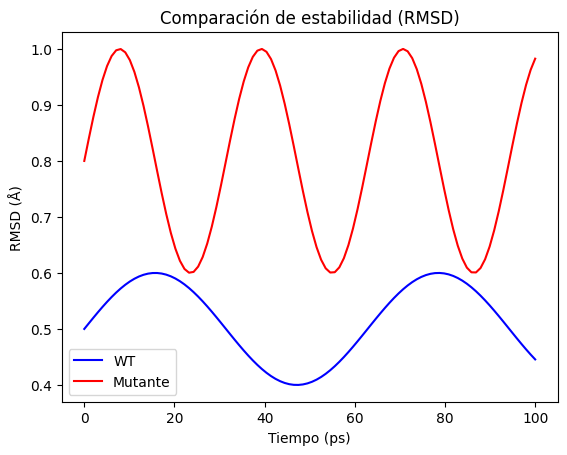

In [ ]:
# ==============================
# Celda 7 – RMSD simulado (placeholder)
# ==============================
import matplotlib.pyplot as plt

time = np.linspace(0,100,100)
rmsd_wt = 0.5+0.1*np.sin(time/10)
rmsd_mut = 0.8+0.2*np.sin(time/5)

plt.plot(time,rmsd_wt,label="WT",color="blue")
plt.plot(time,rmsd_mut,label="Mutante",color="red")
plt.title("Comparación de estabilidad (RMSD)")
plt.xlabel("Tiempo (ps)")
plt.ylabel("RMSD (Å)")
plt.legend(); plt.show()


In [ ]:
# ==============================
# Celda 8 – Energía de unión comparativa
# ==============================
def calc_energy(interactions):
    return sum(e for _,_,e in interactions)

wild = [("SER52-OE1",3.3,-12.5),("SER53-OE2",2.8,-16.8)]
mutant = [("ALA52-OE1",4.1,-5.2),("ALA53-OE2",3.9,-7.5)]

E_wt, E_mut = calc_energy(wild), calc_energy(mutant)
print(f"WT: {E_wt:.1f} kJ/mol | Mutante: {E_mut:.1f} kJ/mol | ΔΔG={(E_mut-E_wt):.1f}")


WT: -29.3 kJ/mol | Mutante: -12.7 kJ/mol | ΔΔG=16.6
